# Seattle Crime prediction 

In [ ]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from datetime import datetime
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit
from matplotlib.colors import LogNorm
from sklearn.decomposition import PCA
from keras.layers.advanced_activations import PReLU
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.utils import np_utils
from copy import deepcopy
%matplotlib inline  

# Import Seattle PD reported incidents from past ~10 years

In [2]:
# Download data from
# https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f
data=pd.read_csv("Seattle_Police_Department_Police_Report_Incident.csv")

# Look at the data

In [4]:
print data.shape
data.head()

(632494, 19)


,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,575312,2015391803,5015,1,WARRARR-FELONY,5000,WARRANT ARREST,11/09/2015 02:23:00 PM,11/09/2015 10:41:00 AM,11/09/2015 10:41:00 AM,2XX BLOCK OF PIKE ST,M,M3,8100.2007,-122.338348,47.609517,"(47.609517442, -122.338348302)",11,2015
1,575376,2015391733,X,69,VEH-RCVD-FOR OTHER AGENCY,X,VEHICLE THEFT,11/09/2015 01:45:00 PM,11/09/2015 01:45:00 PM,NaN,59XX BLOCK OF 4 AV S,O,O3,10900.2067,-122.329581,47.549255,"(47.549255046, -122.329580809)",11,2015
2,575313,2015391987,5015,2,WARRARR-MISDEMEANOR,5000,WARRANT ARREST,11/09/2015 01:16:00 PM,11/09/2015 01:16:00 PM,11/09/2015 01:16:00 PM,1XX BLOCK OF BROADWAY E,E,E1,7402.1010,-122.320864,47.619324,"(47.619323645, -122.320863689)",11,2015
3,575378,2015391849,5015,1,WARRARR-FELONY,5000,WARRANT ARREST,11/09/2015 11:19:00 AM,11/09/2015 11:19:00 AM,NaN,2 AV / PIKE ST,M,M3,8100.3003,-122.338907,47.609284,"(47.60928404, -122.338906796)",11,2015
4,575375,2015391793,2404,8,VEH-THEFT-TRUCK,2400,VEHICLE THEFT,11/09/2015 10:22:00 AM,11/08/2015 04:00:00 PM,11/09/2015 07:00:00 AM,11XX BLOCK OF NW LEARY WY,B,B2,4700.2060,-122.372180,47.663660,"(47.663659815, -122.372180162)",11,2015


# Clean up latitude (Y) and longitude (X) data

In [ ]:
data.rename(columns = {'Latitude':'Y', 'Longitude':'X'}, inplace = True)
data2 = data[(data['X']<-122) & (data['X']>-123) & (data['Year']>2010)]

xy_scaler=preprocessing.StandardScaler()
xy_scaler.fit(data2[["X","Y"]])
data2[["X","Y"]]=xy_scaler.transform(data2[["X","Y"]])
data2=data2[abs(data2["Y"])<100]
data2.index=range(len(data2))

# Plot Seattle crime maps

In [ ]:
plt.figure(figsize=(16, 16))
plt.subplot(1,2,1)
plt.plot(data2["X"],data2["Y"],'.k',markersize=0.5)
plt.axis([-3.5 , 3.5 , -3.2 , 3])
plt.title('Seattle Crime Map')

plt.subplot(1,2,2)
NX=400
NY=400
histo, xedges, yedges = np.histogram2d(data2['X'],data2['Y'], bins=(NX,NY))
myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
plt.axis([-3.5 , 3.5 , -3.2 , 3])
plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
plt.title('Seattle Crime Heatmap')
# plt.show()
print histo.shape , xedges.shape, yedges.shape
print histo

# Inspect the different types of offenses

In [234]:
groups = data2.groupby('Offense Type')
for name, group in groups:
    print name , group.shape


ANIMAL-BITE (671, 19)
ANIMAL-CRUELTY (142, 19)
ANIMAL-OTH (445, 19)
ASSLT-AGG-BODYFORCE (2354, 19)
ASSLT-AGG-GUN (763, 19)
ASSLT-AGG-POLICE-BODYFORCE (49, 19)
ASSLT-AGG-POLICE-GUN (7, 19)
ASSLT-AGG-POLICE-WEAPON (124, 19)
ASSLT-AGG-WEAPON (5225, 19)
ASSLT-NONAGG (17336, 19)
ASSLT-NONAGG-POLICE (705, 19)
ASSLT-OTHER (5, 19)
BIAS INCIDENT (91, 19)
BRIBERY (2, 19)
BURGLARY-FORCE-NONRES (8915, 19)
BURGLARY-FORCE-RES (21315, 19)
BURGLARY-NOFORCE-NONRES (4761, 19)
BURGLARY-NOFORCE-RES (13211, 19)
BURGLARY-SECURE PARKING-NONRES (621, 19)
BURGLARY-SECURE PARKING-RES (5690, 19)
COUNTERFEIT (1381, 19)
DISORDERLY CONDUCT (148, 19)
DISPUTE-CIVIL PROPERTY (AUTO) (226, 19)
DISPUTE-CIVIL PROPERTY (NON AU (824, 19)
DISPUTE-OTH (1345, 19)
DISTURBANCE-NOISE (768, 19)
DISTURBANCE-OTH (16385, 19)
DRIVE-BY (162, 19)
DUI-DRUGS (63, 19)
DUI-LIQUOR (713, 19)
ELUDING-FELONY FLIGHT (120, 19)
EMBEZZLE (1004, 19)
ENDANGER (4, 19)
ENDANGERMENT (96, 19)
ESCAPE (36, 19)
EXTORTION (64, 19)
FALSE REPORT (344, 19)
FIRE

# Break Offense Types into Categories

In [235]:
# Important that 'THEFT' comes before 'THEFT' subcategories in list
categories = ['ASSLT','BURGLARY','COUNTERFEIT','DISTURBANCE','DUI','FORGERY','FRAUD',
              'HARASSMENT','HOMICIDE','NARC','PROPERTY DAMAGE','PROPERTY FOUND','PROSTITUTION', 'ROBBERY', 
              'THEFT','THEFT-BUILDING','THEFT-BICYCLE','THEFT-CARPROWL','THEFT-SHOPLIFT','THREATS','VEH-THEFT','WARR','WEAPON']

data2['Category'] = np.nan 
for category in categories:
    # print category
    for name, group in groups: # groups is grouped by 'Offense Type'
        if category in name:
            if category=='COUNTERFEIT' or category=='FORGERY' or category=='FRAUD':
                data2.ix[data2['Offense Type']==name, 'Category'] = 'FRAUD'
            elif category=='THEFT': #and 'VEH-THEFT' in name:
                data2.ix[data2['Offense Type']==name, 'Category'] = 'THEFT-OTHER'
            else:
                data2.ix[data2['Offense Type']==name, 'Category'] = category

# Anything not in the above categories is classified as "OTHER"
data2.ix[data2['Category'].isnull(), 'Category'] = 'OTHER'
data2.head()

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,X,Y,Location,Month,Year,Category
0,575312,2015391803,5015,1,WARRARR-FELONY,5000,WARRANT ARREST,11/09/2015 02:23:00 PM,11/09/2015 10:41:00 AM,11/09/2015 10:41:00 AM,2XX BLOCK OF PIKE ST,M,M3,8100.2007,-0.247833,-0.242107,"(47.609517442, -122.338348302)",11,2015,WARR
1,575376,2015391733,X,69,VEH-RCVD-FOR OTHER AGENCY,X,VEHICLE THEFT,11/09/2015 01:45:00 PM,11/09/2015 01:45:00 PM,NaN,59XX BLOCK OF 4 AV S,O,O3,10900.2067,0.039843,-1.328869,"(47.549255046, -122.329580809)",11,2015,OTHER
2,575313,2015391987,5015,2,WARRARR-MISDEMEANOR,5000,WARRANT ARREST,11/09/2015 01:16:00 PM,11/09/2015 01:16:00 PM,11/09/2015 01:16:00 PM,1XX BLOCK OF BROADWAY E,E,E1,7402.1010,0.325866,-0.065264,"(47.619323645, -122.320863689)",11,2015,WARR
3,575378,2015391849,5015,1,WARRARR-FELONY,5000,WARRANT ARREST,11/09/2015 11:19:00 AM,11/09/2015 11:19:00 AM,NaN,2 AV / PIKE ST,M,M3,8100.3003,-0.266159,-0.246317,"(47.60928404, -122.338906796)",11,2015,WARR
4,575375,2015391793,2404,8,VEH-THEFT-TRUCK,2400,VEHICLE THEFT,11/09/2015 10:22:00 AM,11/08/2015 04:00:00 PM,11/09/2015 07:00:00 AM,11XX BLOCK OF NW LEARY WY,B,B2,4700.2060,-1.357914,0.734286,"(47.663659815, -122.372180162)",11,2015,VEH-THEFT


# Map data by crime category

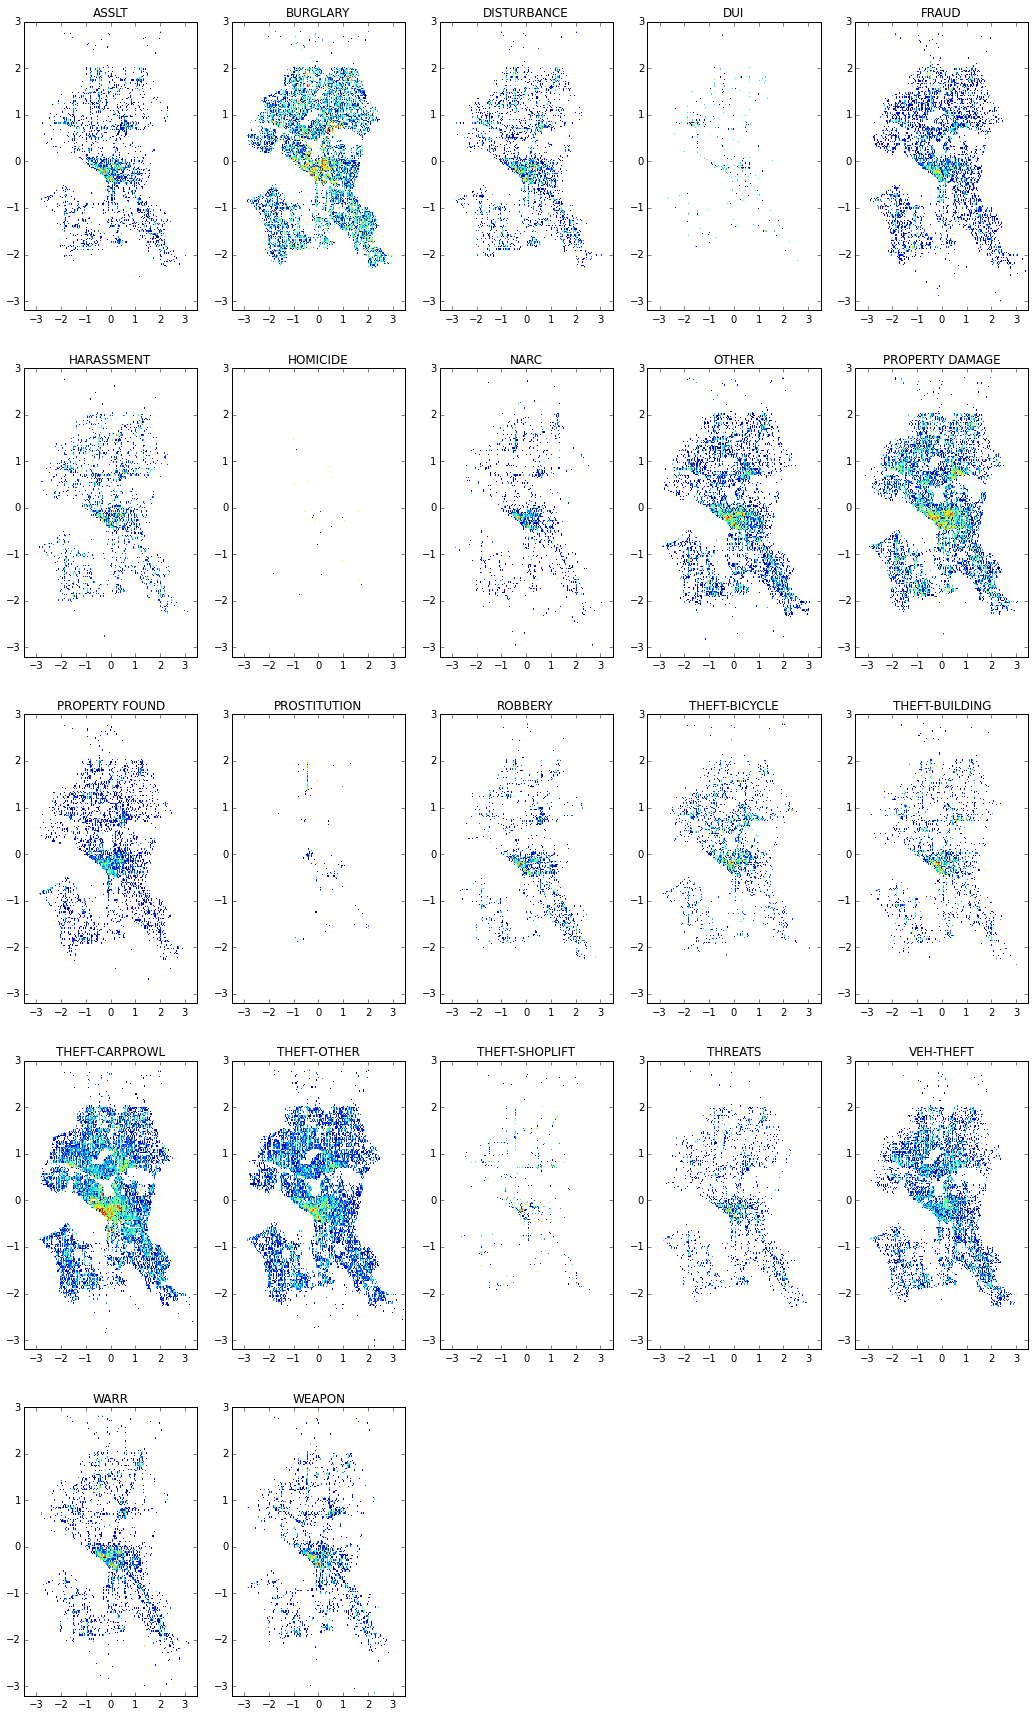

In [236]:
NX=200
NY=200
k=1
groups = data2.groupby('Category')
plt.figure(figsize=(18,30))
for name, group in groups:
    plt.subplot(5,5,k)
    plt.axis([-3.5 , 3.5 , -3.2 , 3])
    histo, xedges, yedges = np.histogram2d(np.array(group.X),np.array(group.Y), bins=(NX,NY))
    myextent  =[xedges[0],xedges[-1],yedges[0],yedges[-1]]
    plt.imshow(histo.T,origin='low',extent=myextent,interpolation='nearest',aspect='auto',norm=LogNorm())
    plt.title(name)
    k+=1
# del groups

# Feature engineering of time and date data

In [237]:
# Function to parse time and date variables
def parse_time(x):
    DD=datetime.strptime(x,"%m/%d/%Y %I:%M:%S %p") # am/pm will be converted to a 24 hour clock
    time=round((DD.hour*60+DD.minute)/60)
    day=DD.day
    month=DD.month
    year=DD.year
    weekday=DD.weekday()
    return time,day,month,year,weekday

# Function to parse season from months
def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring

# add time, date, and season features to the dataset 
data2["startTime"], data2["startDay"], data2["startMonth"], data2["startYear"], data2["weekDay"]=zip(*data2["Occurred Date or Date Range Start"].apply(parse_time))

# Optionally get a one-hot representation of season
data2["Summer"], data2["Fall"], data2["Winter"], data2["Spring"]=zip(*data2["Month"].apply(get_season))


print data2.columns.tolist() # Print out list of features (columns) now in the dataset
data2.head() # have a look at the dataset

['RMS CDW ID', 'General Offense Number', 'Offense Code', 'Offense Code Extension', 'Offense Type', 'Summary Offense Code', 'Summarized Offense Description', 'Date Reported', 'Occurred Date or Date Range Start', 'Occurred Date Range End', 'Hundred Block Location', 'District/Sector', 'Zone/Beat', 'Census Tract 2000', 'X', 'Y', 'Location', 'Month', 'Year', 'Category', 'startTime', 'startDay', 'startMonth', 'startYear', 'weekDay', 'Summer', 'Fall', 'Winter', 'Spring']


,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,...,Category,startTime,startDay,startMonth,startYear,weekDay,Summer,Fall,Winter,Spring
0,575312,2015391803,5015,1,WARRARR-FELONY,5000,WARRANT ARREST,11/09/2015 02:23:00 PM,11/09/2015 10:41:00 AM,11/09/2015 10:41:00 AM,...,WARR,10,9,11,2015,0,0,0,1,0
1,575376,2015391733,X,69,VEH-RCVD-FOR OTHER AGENCY,X,VEHICLE THEFT,11/09/2015 01:45:00 PM,11/09/2015 01:45:00 PM,NaN,...,OTHER,13,9,11,2015,0,0,0,1,0
2,575313,2015391987,5015,2,WARRARR-MISDEMEANOR,5000,WARRANT ARREST,11/09/2015 01:16:00 PM,11/09/2015 01:16:00 PM,11/09/2015 01:16:00 PM,...,WARR,13,9,11,2015,0,0,0,1,0
3,575378,2015391849,5015,1,WARRARR-FELONY,5000,WARRANT ARREST,11/09/2015 11:19:00 AM,11/09/2015 11:19:00 AM,NaN,...,WARR,11,9,11,2015,0,0,0,1,0
4,575375,2015391793,2404,8,VEH-THEFT-TRUCK,2400,VEHICLE THEFT,11/09/2015 10:22:00 AM,11/08/2015 04:00:00 PM,11/09/2015 07:00:00 AM,...,VEH-THEFT,16,8,11,2015,6,0,0,1,0


# Plot heat maps of crime categories according to temporal features (e.g., day, time, month...)

In [238]:
def heat_grid(x,y,norm):
    crosstab = pd.crosstab(x,y,margins=True)
    del crosstab['All']#delete All column
    crosstab = crosstab.ix[:-1]#delete last row (All)
    
    fig,ax = pplt.subplots()
    
    # if norm==True then normalize each category to itself 
    if norm==True: 
        crosstab=crosstab/crosstab.sum(axis=0)
        heatmap = ax.pcolor(crosstab,cmap=pplt.cm.YlOrRd)
    else:
        heatmap = ax.pcolor(crosstab,cmap=pplt.cm.Blues)


    column_labels = list(crosstab.columns.values)
    row_labels = crosstab.index.values.tolist()
    
    #format
    fig = pplt.gcf()
    fig.set_size_inches(15,len(x.unique())/4.)
    #turn off the frame
    ax.set_frame_on(False)
    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(crosstab.shape[0])+0.5, minor=False)
    ax.set_xticks(np.arange(crosstab.shape[1])+0.5, minor=False)
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    ax.set_xticklabels(column_labels, minor=False)
    ax.set_yticklabels(row_labels, minor=False)
    #rotate
    pplt.xticks(rotation=90)
    #remove gridlines
    ax.grid(False)
    # Turn off all the ticks
    ax = pplt.gca()
    for t in ax.xaxis.get_major_ticks(): 
        t.tick1On = False 
        t.tick2On = False 
    for t in ax.yaxis.get_major_ticks(): 
        t.tick1On = False 
        t.tick2On = False  
    
    pplt.show()   

    
# ['District/Sector','Zone/Beat','startTime', 'weekDay','startDay','startMonth','startYear']:

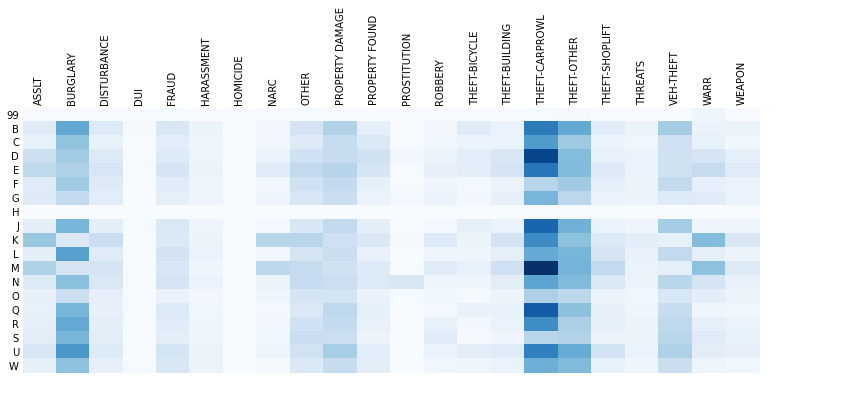

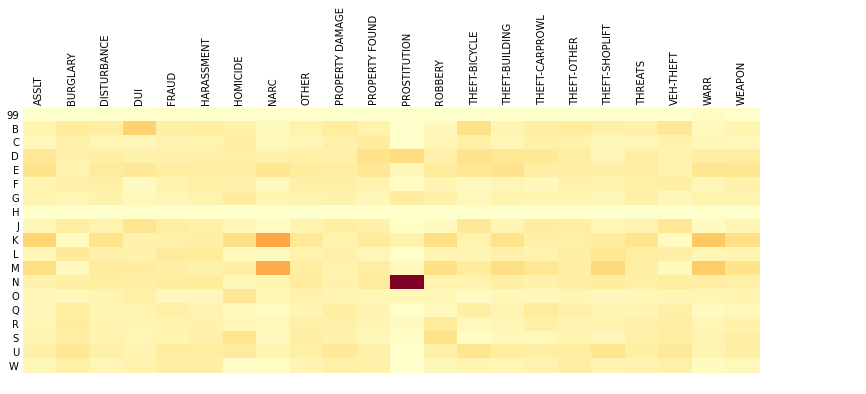

In [239]:
heat_grid(data2['District/Sector'],data2.Category,norm=False)
heat_grid(data2['District/Sector'],data2.Category,norm=True)

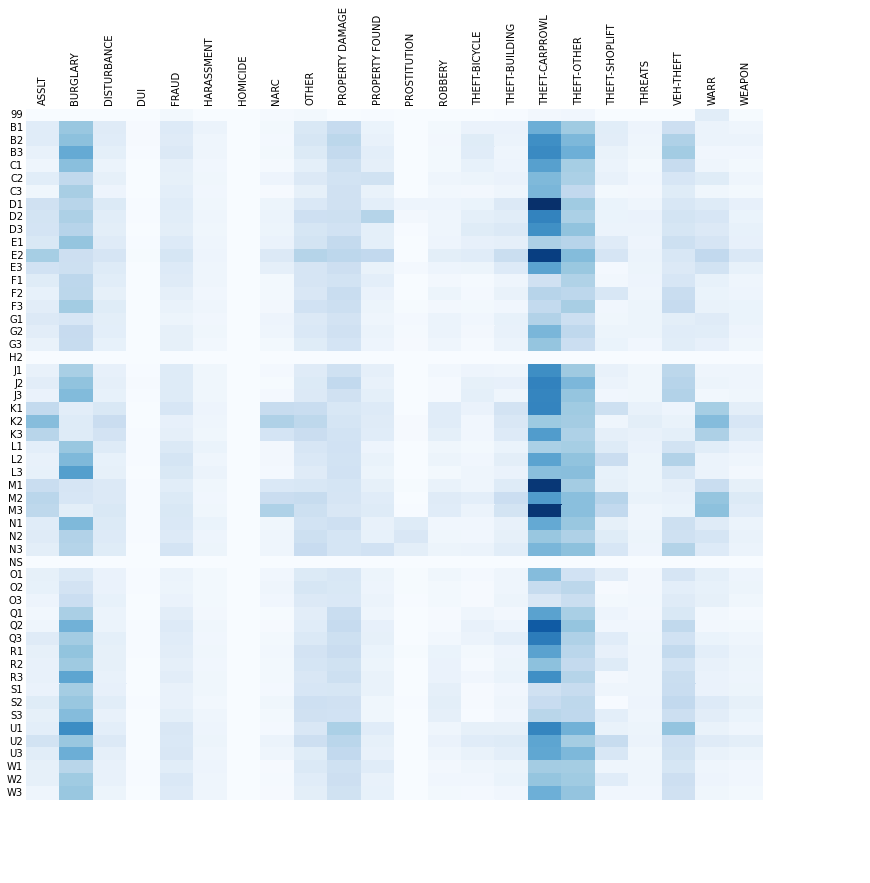

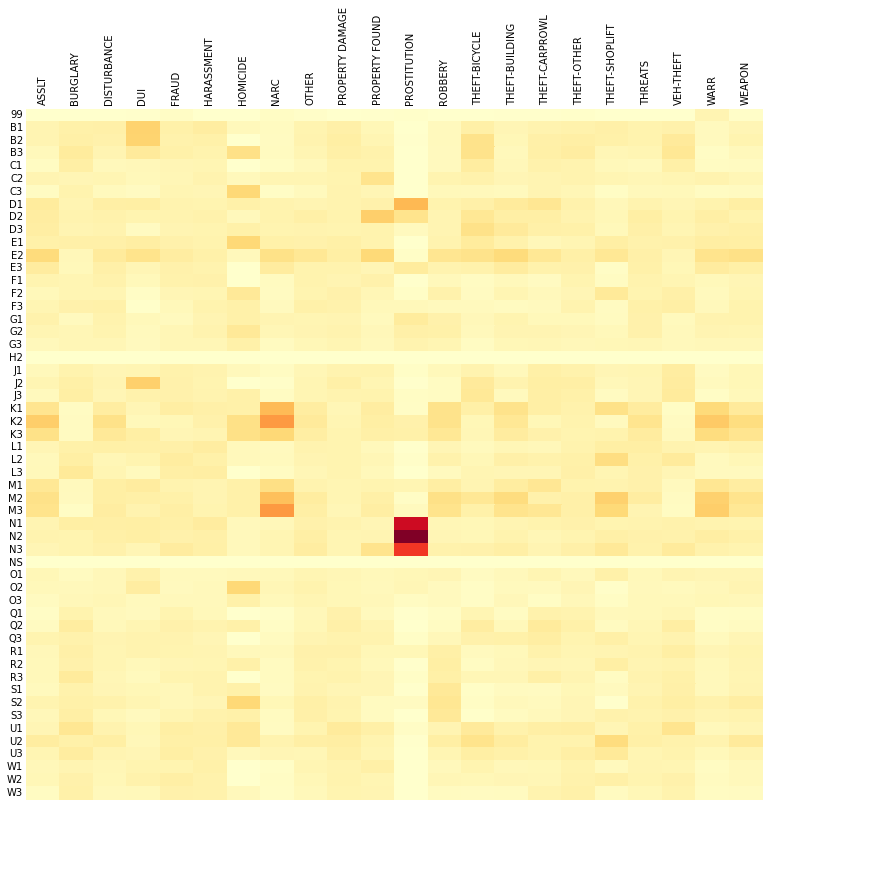

In [240]:
heat_grid(data2['Zone/Beat'],data2.Category,norm=False)
heat_grid(data2['Zone/Beat'],data2.Category,norm=True)

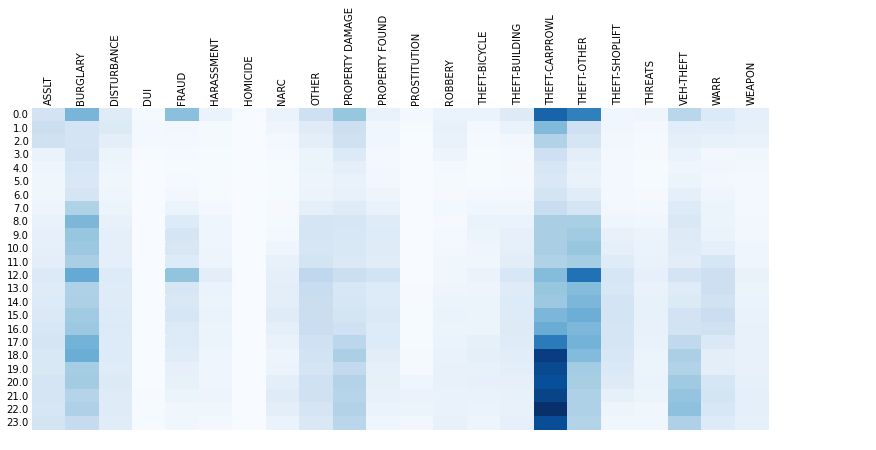

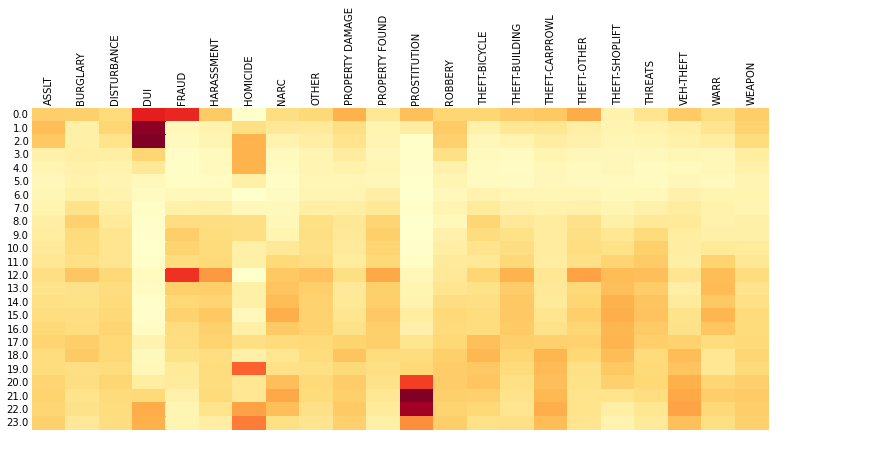

In [241]:
heat_grid(data2['startTime'],data2.Category,norm=False)
heat_grid(data2['startTime'],data2.Category,norm=True)

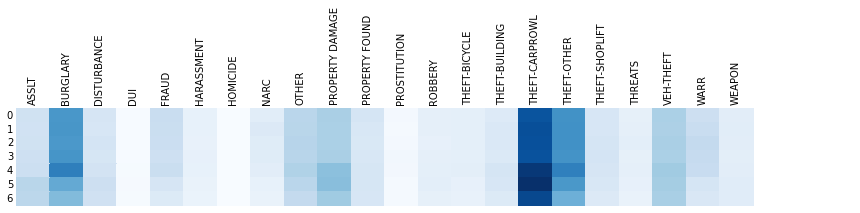

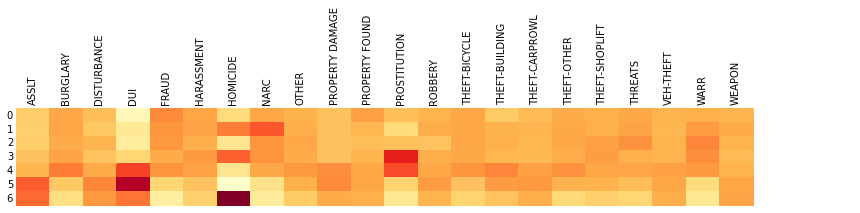

In [242]:
heat_grid(data2['weekDay'],data2.Category,norm=False)
heat_grid(data2['weekDay'],data2.Category,norm=True)

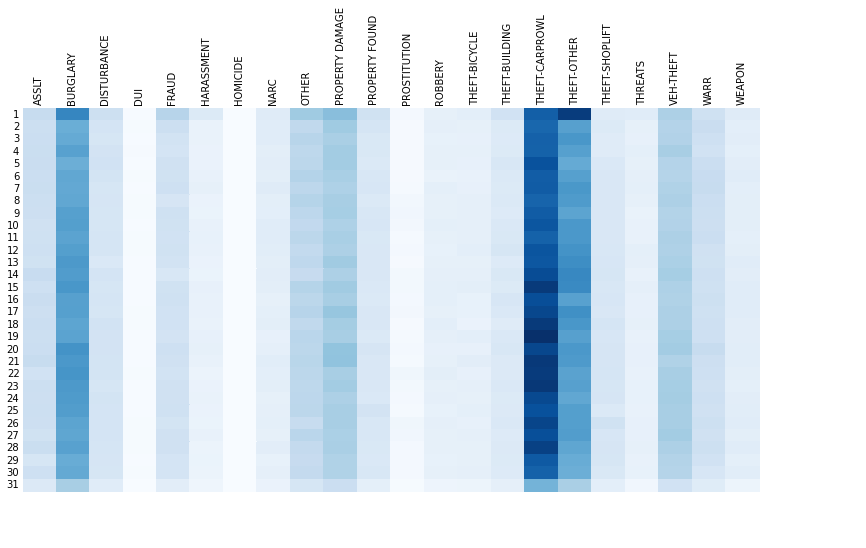

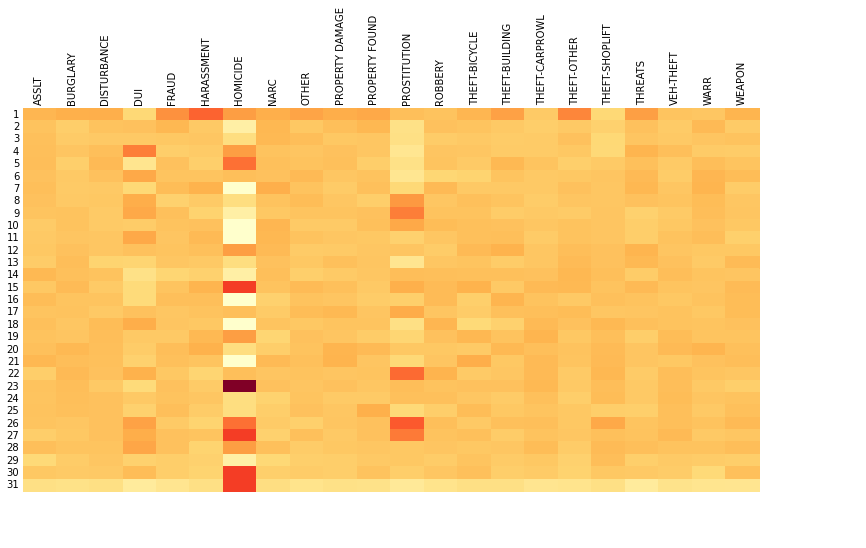

In [243]:
heat_grid(data2['startDay'],data2.Category,norm=False)
heat_grid(data2['startDay'],data2.Category,norm=True)

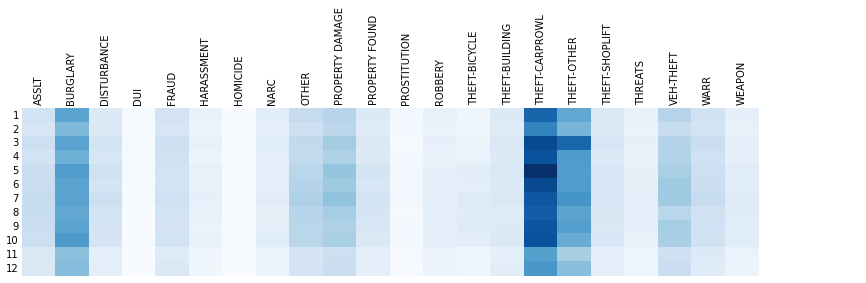

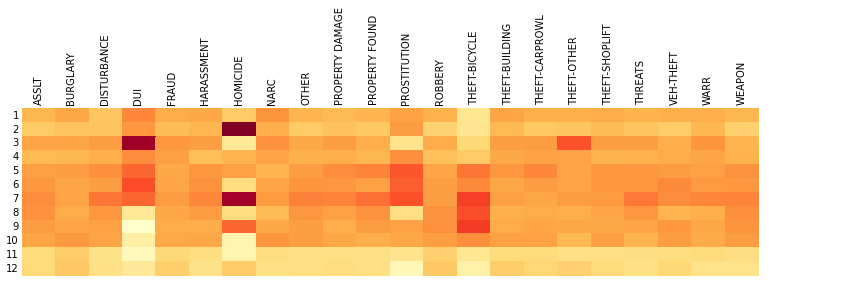

In [244]:
heat_grid(data2['startMonth'],data2.Category,norm=False)
heat_grid(data2['startMonth'],data2.Category,norm=True)

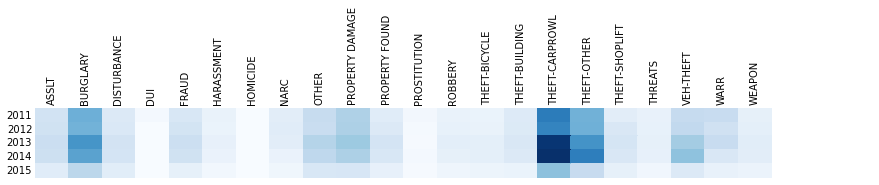

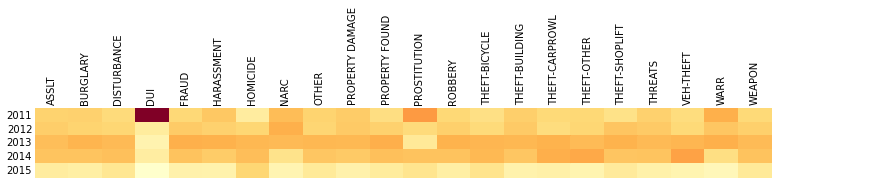

In [245]:
heat_grid(data2['startYear'],data2.Category,norm=False)
heat_grid(data2['startYear'],data2.Category,norm=True)

# Too many unique block addresses for training a model

In [246]:
print data2.shape, data2["Hundred Block Location"].unique().shape
data2["Hundred Block Location"].head()

(469102, 29) (38713,)


0         2XX BLOCK OF PIKE ST
1         59XX BLOCK OF 4 AV S
2      1XX BLOCK OF BROADWAY E
3               2 AV / PIKE ST
4    11XX BLOCK OF NW LEARY WY
Name: Hundred Block Location, dtype: object

# Create a block location-crime category log odds scores for all categories and all addresses

In [247]:
# The log odds scores are as follows:
# default_logodds = ln(nCategories/nRows)-ln(1-nCategories/nRows)
# for all addresses and categories, 
#   if there are more than MIN_CAT_COUNTS instances of (thisAddress & thisCategory),
#   and if not every instance of thisAddress is a member of thisCategory,
#   then logodds' = ln(n(thisAddress & thisCategory)/n(thisAddress))-ln(1-n(thisAddress & thisCategory)/n(thisAddress))

data2.ix[data2["Hundred Block Location"].isnull()==True,"Hundred Block Location"] = 'nan'
addresses=sorted(data2["Hundred Block Location"].unique())
#addresses = [x for x in addressses if str(x) != 'nan']

categories=sorted(data2["Category"].unique())
#categories = [x for x in categories if str(x) != 'nan']

A_counts=data2.groupby(["Hundred Block Location"]).size()
C_counts=data2.groupby(["Category"]).size()
A_C_counts=data2.groupby(["Hundred Block Location","Category"]).size()
logodds={}
logoddsPA={}
MIN_CAT_COUNTS=0 #2
default_logodds=np.log(C_counts/len(data2))-np.log(1.0-C_counts/float(len(data2)))
for addr in addresses:
    PA=A_counts[addr]/float(len(data2))
    logoddsPA[addr]=np.log(PA)-np.log(1.-PA)
    logodds[addr]=deepcopy(default_logodds)
    for cat in A_C_counts[addr].keys():
        if (A_C_counts[addr][cat]>MIN_CAT_COUNTS) and A_C_counts[addr][cat]<A_counts[addr]:
            PA=A_C_counts[addr][cat]/float(A_counts[addr])
            logodds[addr][categories.index(cat)]=np.log(PA)-np.log(1.0-PA)
    logodds[addr]=pd.Series(logodds[addr])
    logodds[addr].index=range(len(categories))

## Transform block location-crime category log odds scores into features that can be added to the dataset for training a learner

In [248]:
blocklogloss=data2["Hundred Block Location"].apply(lambda x: logodds[x])
blocklogloss.columns=["logodds"+str(x) for x in range(len(blocklogloss.columns))]

print blocklogloss.shape 

(469102, 22)


# Create one-hot ("binarized") representations of weekday, district, zone...

In [249]:
# Create one-hot representations of a bunch of time/location data
OHhour = pd.get_dummies(data2["startTime"],prefix="hr") # Hour of day (rounded to nearest)
OHday = pd.get_dummies(data2["startDay"],prefix="d") # Day of month
OHweekday = pd.get_dummies(data2["weekDay"],prefix="wd") # Day of week
OHmonth = pd.get_dummies(data2["startMonth"],prefix="mon") # Month
OHyear = pd.get_dummies(data2["startYear"],prefix="yr") # Month

OHsector = pd.get_dummies(data2["District/Sector"],prefix="sect") # Creates one-hot weekdays
OHzone = pd.get_dummies(data2["Zone/Beat"],prefix="zone") # Creates one-hot weekdays

# check dimensionality of one-hot representations
print OHhour.shape, OHday.shape, OHweekday.shape, OHmonth.shape, OHyear.shape, OHsector.shape, OHzone.shape 

# add selected one-hot encoded features to dataset
data2 = (data2.join(OHweekday.ix[:,:]).join(OHsector.ix[:,:]).join(OHzone.ix[:,:])
            .join(blocklogloss.ix[:,:]))

(469102, 24) (469102, 31) (469102, 7) (469102, 12) (469102, 5) (469102, 19) (469102, 54)


# Construct a Features dataframe and a Labels column for training the model

In [353]:
labels=data2['Category'] # The labels are the crime categories that we seek to predict
catlabels = labels.astype('category')

# Add a binary variable encoding whether the block location is an intersection or not
data2["intx"]=data2["Hundred Block Location"].apply(lambda x: 1 if "/" in x else 0)

# Features from dataset that will be used in the model, in addition to one-hot weekday data
keepFeatures=['X','Y','intx','startTime','startDay','startMonth','startYear','Summer','Fall','Winter','Spring']

# Combine features from dataset with selected one-hot encoded features
features1 = (data2[keepFeatures].join(OHsector.ix[:,:]).join(OHzone.ix[:,:])
            .join(blocklogloss.ix[:,:]))

features2 = (data2[keepFeatures].join(OHsector.ix[:,:]).join(OHzone.ix[:,:]))
features3 = blocklogloss

print features1.shape
print features2.shape
print features3.shape

(469102, 106)
(469102, 84)
(469102, 22)


# Normalize all features to a (Z-score)

In [354]:
# num_feature_list=["Time","Day","Month","Year","DayOfWeek"]
def norm(x):
    collist=x.columns.tolist()
    scaler = preprocessing.StandardScaler()
    scaler.fit(x)
    x[collist]=scaler.transform(x)

    #print x.shape
    #print x.columns.tolist()
    #x.head()
    return x
    
features1=norm(features1)
features2=norm(features2)
features3=norm(features3)

# Perform PCA

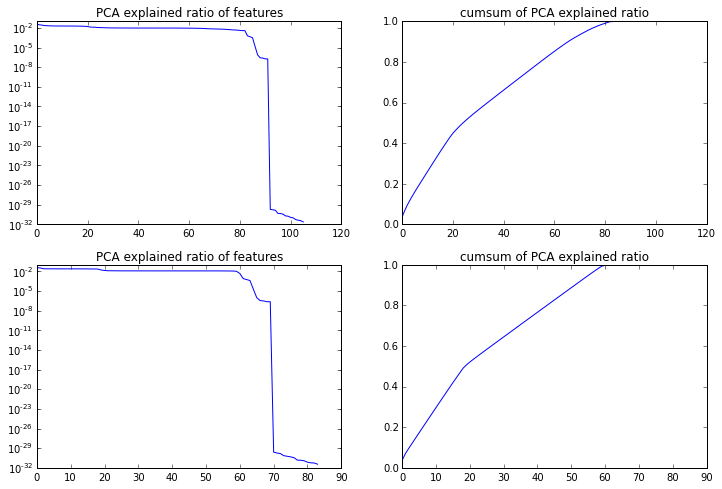

In [340]:
new_PCA1=PCA(n_components=features1.shape[1])
new_PCA1.fit(features1)
new_PCA2=PCA(n_components=features2.shape[1])
new_PCA2.fit(features2)

plt.figure(figsize=(12, 8))
plt.subplot(2,2,1)
plt.plot(new_PCA1.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")

plt.subplot(2,2,2)
plt.plot(new_PCA1.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")

plt.subplot(2,2,3)
plt.plot(new_PCA2.explained_variance_ratio_)
plt.yscale('log')
plt.title("PCA explained ratio of features")

plt.subplot(2,2,4)
plt.plot(new_PCA2.explained_variance_ratio_.cumsum())
plt.title("cumsum of PCA explained ratio")



In [341]:
new_PCA=PCA(n_components=60)
new_PCA.fit(features1)
features1=pd.DataFrame(new_PCA.transform(features1))

new_PCA=PCA(n_components=60)
new_PCA.fit(features2)
features2=pd.DataFrame(new_PCA.transform(features2))


In [355]:
features1.head()

,X,Y,intx,startTime,startDay,startMonth,startYear,Summer,Fall,Winter,...,logodds12,logodds13,logodds14,logodds15,logodds16,logodds17,logodds18,logodds19,logodds20,logodds21
0,-0.247833,-0.242107,-0.415564,-0.468642,-0.764477,1.438153,1.653924,-0.632336,-0.602086,2.489183,...,1.270917,-0.176969,-0.717245,-1.351966,-0.992413,1.614574,-1.309034,-3.387811,2.189324,0.078572
1,0.039843,-1.328869,-0.415564,-0.030284,-0.764477,1.438153,1.653924,-0.632336,-0.602086,2.489183,...,-0.322863,-0.176969,-0.287906,-0.760071,-0.357130,-0.220929,-0.724310,-0.729144,-1.202779,-1.183445
2,0.325866,-0.065264,-0.415564,-0.030284,-0.764477,1.438153,1.653924,-0.632336,-0.602086,2.489183,...,-3.197286,-0.176969,-3.623084,-2.275407,-0.861685,-1.429360,0.160938,0.130952,1.960000,0.905089
3,-0.266159,-0.246317,2.406368,-0.322523,-0.764477,1.438153,1.653924,-0.632336,-0.602086,2.489183,...,0.501146,-1.164972,-2.465085,-0.441187,-0.094974,-2.577581,-2.433163,-1.217906,2.809961,-0.360181
4,-1.357914,0.734286,-0.415564,0.408074,-0.878058,1.438153,1.653924,-0.632336,-0.602086,2.489183,...,0.766401,-0.176969,-0.287906,-0.601606,1.040547,1.966095,0.847480,1.099976,-1.326342,0.471575


# Split features and labels into testing and training sets

In [356]:
labels = labels.astype('category')
sss = StratifiedShuffleSplit(labels, train_size=0.5)
for train_index, test_index in sss:
        labels_train,labels_test=labels[train_index],labels[test_index]
        features_train1,features_test1=features1.iloc[train_index],features1.iloc[test_index]
        features_train2,features_test2=features2.iloc[train_index],features2.iloc[test_index]
        features_train3,features_test3=features3.iloc[train_index],features3.iloc[test_index]

labels_train.index=range(len(labels_train))
labels_test.index=range(len(labels_test))
labels.index=range(len(labels))

features_test1.index=range(len(features_test1))
features_train1.index=range(len(features_train1))
features1.index=range(len(features1))

features_test2.index=range(len(features_test2))
features_train2.index=range(len(features_train2))
features2.index=range(len(features2))

features_test3.index=range(len(features_test3))
features_train3.index=range(len(features_train3))
features3.index=range(len(features3))

# NN Model

In [357]:
def build_and_fit_model(X_train,y_train,X_test=None,y_test=None,hn=32,dp=0.5,layers=1,epochs=1,batches=64,verbose=0):
    input_dim=X_train.shape[1]
    output_dim=len(labels_train.unique())
    Y_train=np_utils.to_categorical(y_train.cat.rename_categories(range(len(y_train.unique()))))
#     print output_dim

    model = Sequential()
    model.add(Dense(hn, input_shape=(input_dim,))) #model.add(Dense(input_dim, hn, init='glorot_uniform'))
    model.add(PReLU())  # model.add(PReLU((hn,)))
    model.add(Dropout(dp))

    
    for i in range(layers):
      model.add(Dense(hn))  # model.add(Dense(hn, hn, init='glorot_uniform'))
      model.add(PReLU()) # model.add(PReLU((hn,)))
      model.add(BatchNormalization()) # model.add(BatchNormalization((hn,)))
      model.add(Dropout(dp))

    model.add(Dense(output_dim)) # model.add(Dense(hn, output_dim, init='glorot_uniform'))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    if X_test is not None:
        Y_test=np_utils.to_categorical(y_test.cat.rename_categories(range(len(y_test.unique()))))
        fitting=model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose,validation_data=(X_test,Y_test))
        test_score = log_loss(y_test, model.predict_proba(X_test,verbose=0))
    else:
        model.fit(X_train, Y_train, nb_epoch=epochs, batch_size=batches,verbose=verbose)
        fitting=0
        test_score = 0
    return test_score, fitting, model

# Define NN model parameters

In [358]:
N_EPOCHS=50
N_HN=128
N_LAYERS=2
DP=0.125

# Train and fit the NN model

In [359]:
score1, fitting1, model1 = build_and_fit_model(features_train1.as_matrix(),labels_train,X_test=features_test1.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)
score2, fitting2, model2 = build_and_fit_model(features_train2.as_matrix(),labels_train,X_test=features_test2.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)
score3, fitting3, model3 = build_and_fit_model(features_train3.as_matrix(),labels_train,X_test=features_test3.as_matrix(),y_test=labels_test,hn=N_HN,layers=N_LAYERS,epochs=N_EPOCHS,verbose=2,dp=DP)

Train on 234551 samples, validate on 234554 samples
Epoch 1/50
35s - loss: 2.2647 - val_loss: 2.1012
Epoch 2/50
34s - loss: 2.0934 - val_loss: 2.0282
Epoch 3/50
34s - loss: 2.0408 - val_loss: 2.0005
Epoch 4/50
34s - loss: 2.0166 - val_loss: 1.9832
Epoch 5/50
34s - loss: 2.0029 - val_loss: 1.9761
Epoch 6/50
35s - loss: 1.9938 - val_loss: 1.9676
Epoch 7/50
34s - loss: 1.9843 - val_loss: 1.9607
Epoch 8/50
35s - loss: 1.9782 - val_loss: 1.9557
Epoch 9/50
34s - loss: 1.9717 - val_loss: 1.9492
Epoch 10/50
34s - loss: 1.9664 - val_loss: 1.9443
Epoch 11/50
34s - loss: 1.9611 - val_loss: 1.9427
Epoch 12/50
34s - loss: 1.9575 - val_loss: 1.9398
Epoch 13/50
34s - loss: 1.9544 - val_loss: 1.9383
Epoch 14/50
34s - loss: 1.9490 - val_loss: 1.9336
Epoch 15/50
34s - loss: 1.9467 - val_loss: 1.9308
Epoch 16/50
36s - loss: 1.9431 - val_loss: 1.9289
Epoch 17/50
36s - loss: 1.9398 - val_loss: 1.9287
Epoch 18/50
35s - loss: 1.9382 - val_loss: 1.9423
Epoch 19/50
34s - loss: 1.9366 - val_loss: 1.9253
Epoch 2

# Display logloss scores from NN model

In [360]:
predict_default = np.outer(C_counts/float(len(data2)) , np.ones(features.shape[0]), out=None).T
# default_acc = max(C_counts)/len(data2)

predict_all1 = model1.predict_proba(features1.as_matrix(),verbose=0)
predict_train1 = model1.predict_proba(features_train1.as_matrix(),verbose=0)
predict_test1 = model1.predict_proba(features_test1.as_matrix(),verbose=0)

predict_all2 = model2.predict_proba(features2.as_matrix(),verbose=0)
predict_train2 = model2.predict_proba(features_train2.as_matrix(),verbose=0)
predict_test2 = model2.predict_proba(features_test2.as_matrix(),verbose=0)

predict_all3 = model3.predict_proba(features3.as_matrix(),verbose=0)
predict_train3 = model3.predict_proba(features_train3.as_matrix(),verbose=0)
predict_test3 = model3.predict_proba(features_test3.as_matrix(),verbose=0)

A Priori: all - log_loss 2.69818594857

Model 1: all - log_loss 1.87170254988
Model 2: all - log_loss 2.42123702313
Model 3: all - log_loss 1.92241211954

Model 1: train - log_loss 1.83638851225
Model 2: train - log_loss 2.39686125149
Model 3: train - log_loss 1.90872309206

Model 1: test - log_loss 1.90701311137
Model 2: test - log_loss 2.44560902821
Model 3: test - log_loss 1.9361033683


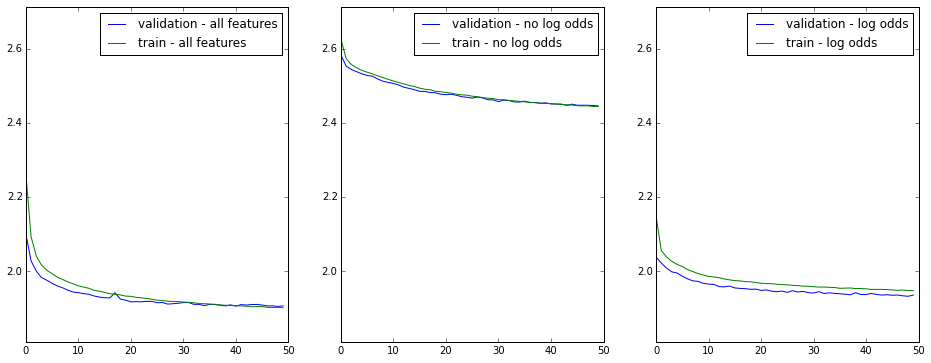

In [361]:
# print max(C_counts)/float(len(data2))                     
# print "all - log_loss", accuracy_score(labels, predict_all)
# print "train - log_loss", accuracy_score(labels_train,predict_train)
# print "test - log_loss", accuracy_score(labels_test,predict_test)
                         
print "A Priori: all - log_loss", log_loss(labels, predict_default)  
print
print "Model 1: all - log_loss", log_loss(labels, predict_all1)
print "Model 2: all - log_loss", log_loss(labels, predict_all2)
print "Model 3: all - log_loss", log_loss(labels, predict_all3)
print
print "Model 1: train - log_loss", log_loss(labels_train,predict_train1)
print "Model 2: train - log_loss", log_loss(labels_train,predict_train2)
print "Model 3: train - log_loss", log_loss(labels_train,predict_train3)
print
print "Model 1: test - log_loss", log_loss(labels_test,predict_test1)
print "Model 2: test - log_loss", log_loss(labels_test,predict_test2)
print "Model 3: test - log_loss", log_loss(labels_test,predict_test3)

Ylim=[0.95*min(min(fitting1.history['val_loss']),min(fitting2.history['val_loss']),min(fitting3.history['val_loss'])),
      1.05*max(max(fitting1.history['val_loss']),max(fitting2.history['val_loss']),max(fitting3.history['val_loss']))]

plt.figure(figsize=(16, 6))
plt.subplot(1,3,1)
plt.plot(fitting1.history['val_loss'],label="validation - all features")
plt.plot(fitting1.history['loss'],label="train - all features")
plt.ylim(Ylim)
# plt.xscale('log')
plt.legend()

plt.subplot(1,3,2)
plt.plot(fitting2.history['val_loss'],label="validation - no log odds")
plt.plot(fitting2.history['loss'],label="train - no log odds")
# plt.xscale('log')
plt.legend()
plt.ylim(Ylim)

plt.subplot(1,3,3)
plt.plot(fitting3.history['val_loss'],label="validation - log odds")
plt.plot(fitting3.history['loss'],label="train - log odds")
# plt.xscale('log')
plt.legend()
plt.ylim(Ylim)

plt.show()

### Training with all features performed the best (log loss score of 1.907 on test data)
### Training with only the log odds of each block address with respect to crime category performed almost as well (log loss score of 1.936 on test data) 
### Training with all features except the log loss score performed the worst (log loss score of 2.446 on test data)
### (The other features were time and date, zone, district, latitude and longitude)